Key Imports

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as dataread
from fredapi import Fred
import matplotlib.pyplot as plt
import yfinance as yf
from matplotlib.ticker import FuncFormatter
import requests
from io import StringIO
from tqdm import tqdm

Define Font Family for Charts

In [2]:
plt.rcParams['font.family'] = 'Arial'

Establish Connection to FRED API

In [3]:
fred = Fred(api_key = "MY_API_KEY")

Get Historical Data on 10Y TIPS from FRED

In [4]:
breakeven_data = fred.get_series("DFII5")
breakeven_df = pd.DataFrame({
    "date": pd.to_datetime(breakeven_data.index),
    "yield": breakeven_data.values
})

Get Historical Gold Spot Price Data from Yahoo Finance

In [5]:
gold_data = yf.download("GC=F", start="2022-01-01", end="2026-02-04")
gold_df = gold_data[['Close']].reset_index()
gold_df.columns = ['date', 'price']

/var/folders/0c/gwf3kkss2ls74cgdgxp9q88r0000gn/T/ipykernel_80670/2891169358.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_data = yf.download("GC=F", start="2022-01-01", end="2026-02-04")
[*********************100%***********************]  1 of 1 completed


Merge Data on Date

In [6]:
data_df = gold_df.merge(breakeven_df, on="date", how="inner")

Plot Data

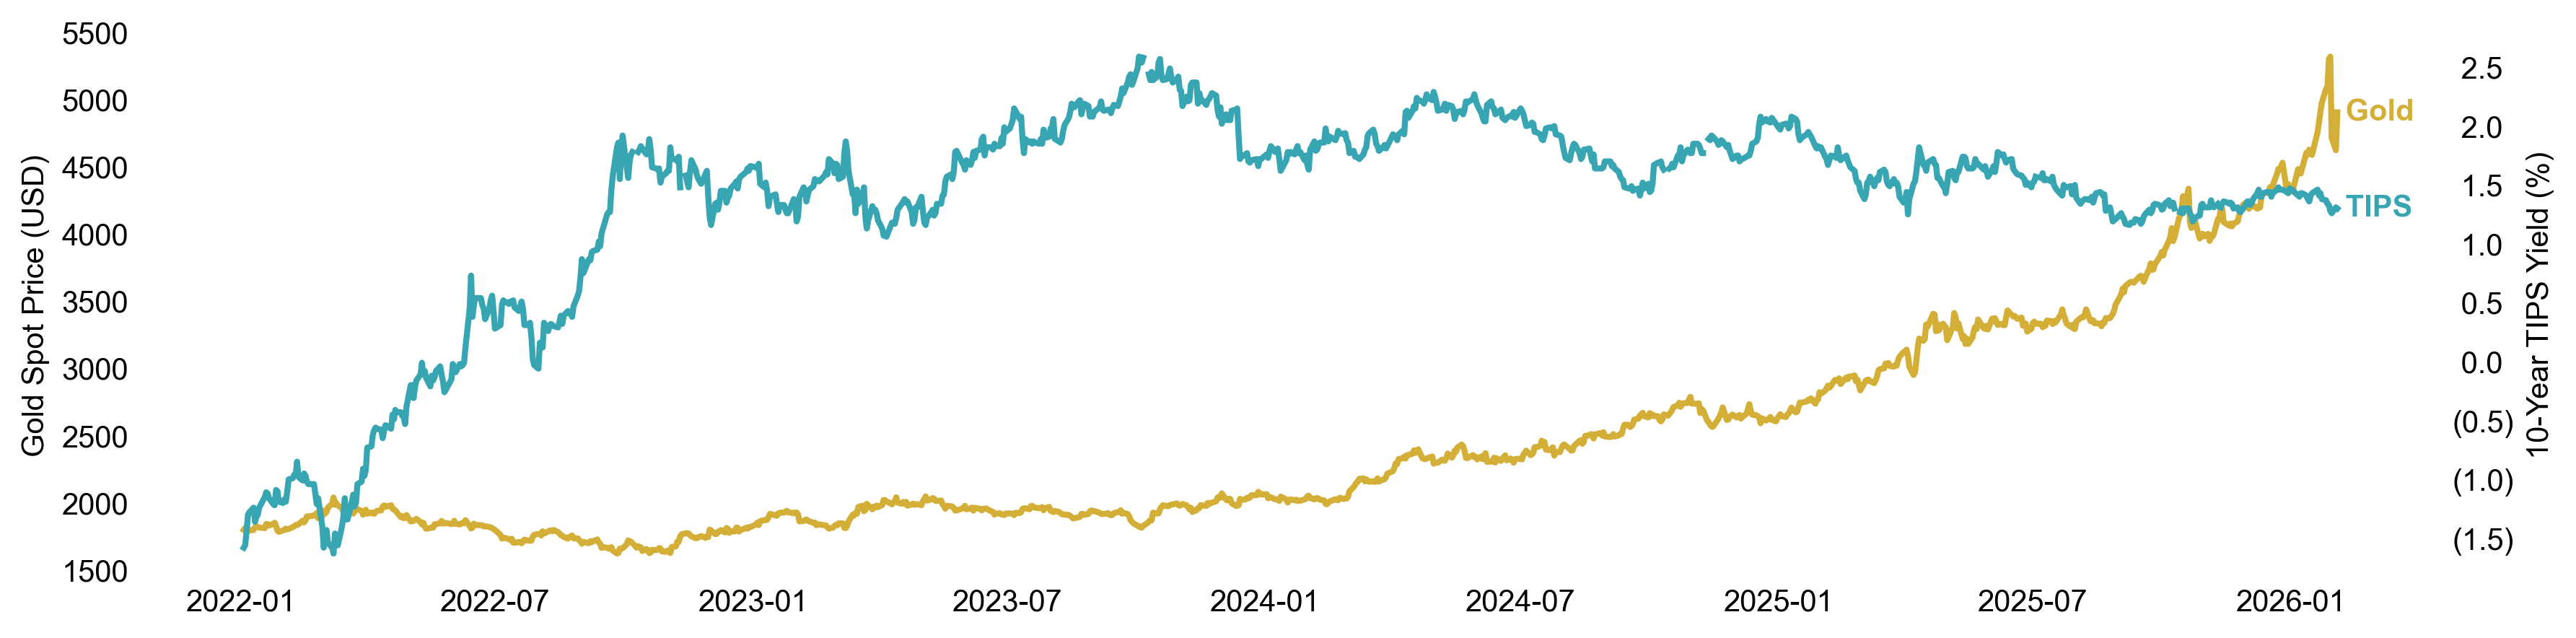

In [7]:
fig, ax1 = plt.subplots(figsize = (12,3), dpi = 300)
ax1.plot(data_df["date"], data_df["price"], color = "#D4AF37", linewidth = 2, label = "Gold Spot Price (USD)")
ax1.set_ylabel("Gold Spot Price (USD)", color = "black", fontsize = 10)
ax1.tick_params(axis = "y", length=0)
ax1.tick_params(axis = "x", length=0)

ax2 = ax1.twinx()
ax2.plot(data_df["date"], data_df["yield"], color = "#38A5B2", linewidth = 2, label = "10Y TIPS Yield")
ax2.set_ylabel("10-Year TIPS Yield (%)", color = "black", fontsize = 10)
ax2.tick_params(axis = "y", length=0)

ax2.yaxis.set_major_locator(plt.MultipleLocator(0.5))

from matplotlib.ticker import FuncFormatter
def format_negative(x, pos):
    if x < 0:
        return f'({abs(x):.1f})'
    else:
        return f' {x:.1f} '

ax2.yaxis.set_major_formatter(FuncFormatter(format_negative))

last_date = data_df["date"].iloc[-1]
last_gold_price = data_df["price"].iloc[-1]
last_tips_yield = data_df["yield"].iloc[-1]

ax1.text(last_date, last_gold_price, ' Gold', fontsize=10, color='#D4AF37', 
         va='center', ha='left', weight='bold')
ax2.text(last_date, last_tips_yield, ' TIPS', fontsize=10, color='#38A5B2', 
         va='center', ha='left', weight='bold')

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)

ax1.grid(False)
fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/gold_and_tips.png")
plt.show()

Calculate Daily Returns and Yield Changes

In [8]:
data = data_df[['date', 'price', 'yield']].copy()
data = data.set_index('date')

data['yield'] = data['yield'].ffill()
data['yield_chg'] = data['yield'].diff()
data['gold_return'] = data['price'].pct_change()

Calculate Rolling Beta Series Inputs and Plug

In [9]:
rolling_cov = data['gold_return'].rolling(window=52).cov(data['yield_chg'])
rolling_var = data['yield_chg'].rolling(window=52).var()
rolling_beta = (rolling_cov / rolling_var).dropna()

Plot Rolling Beta

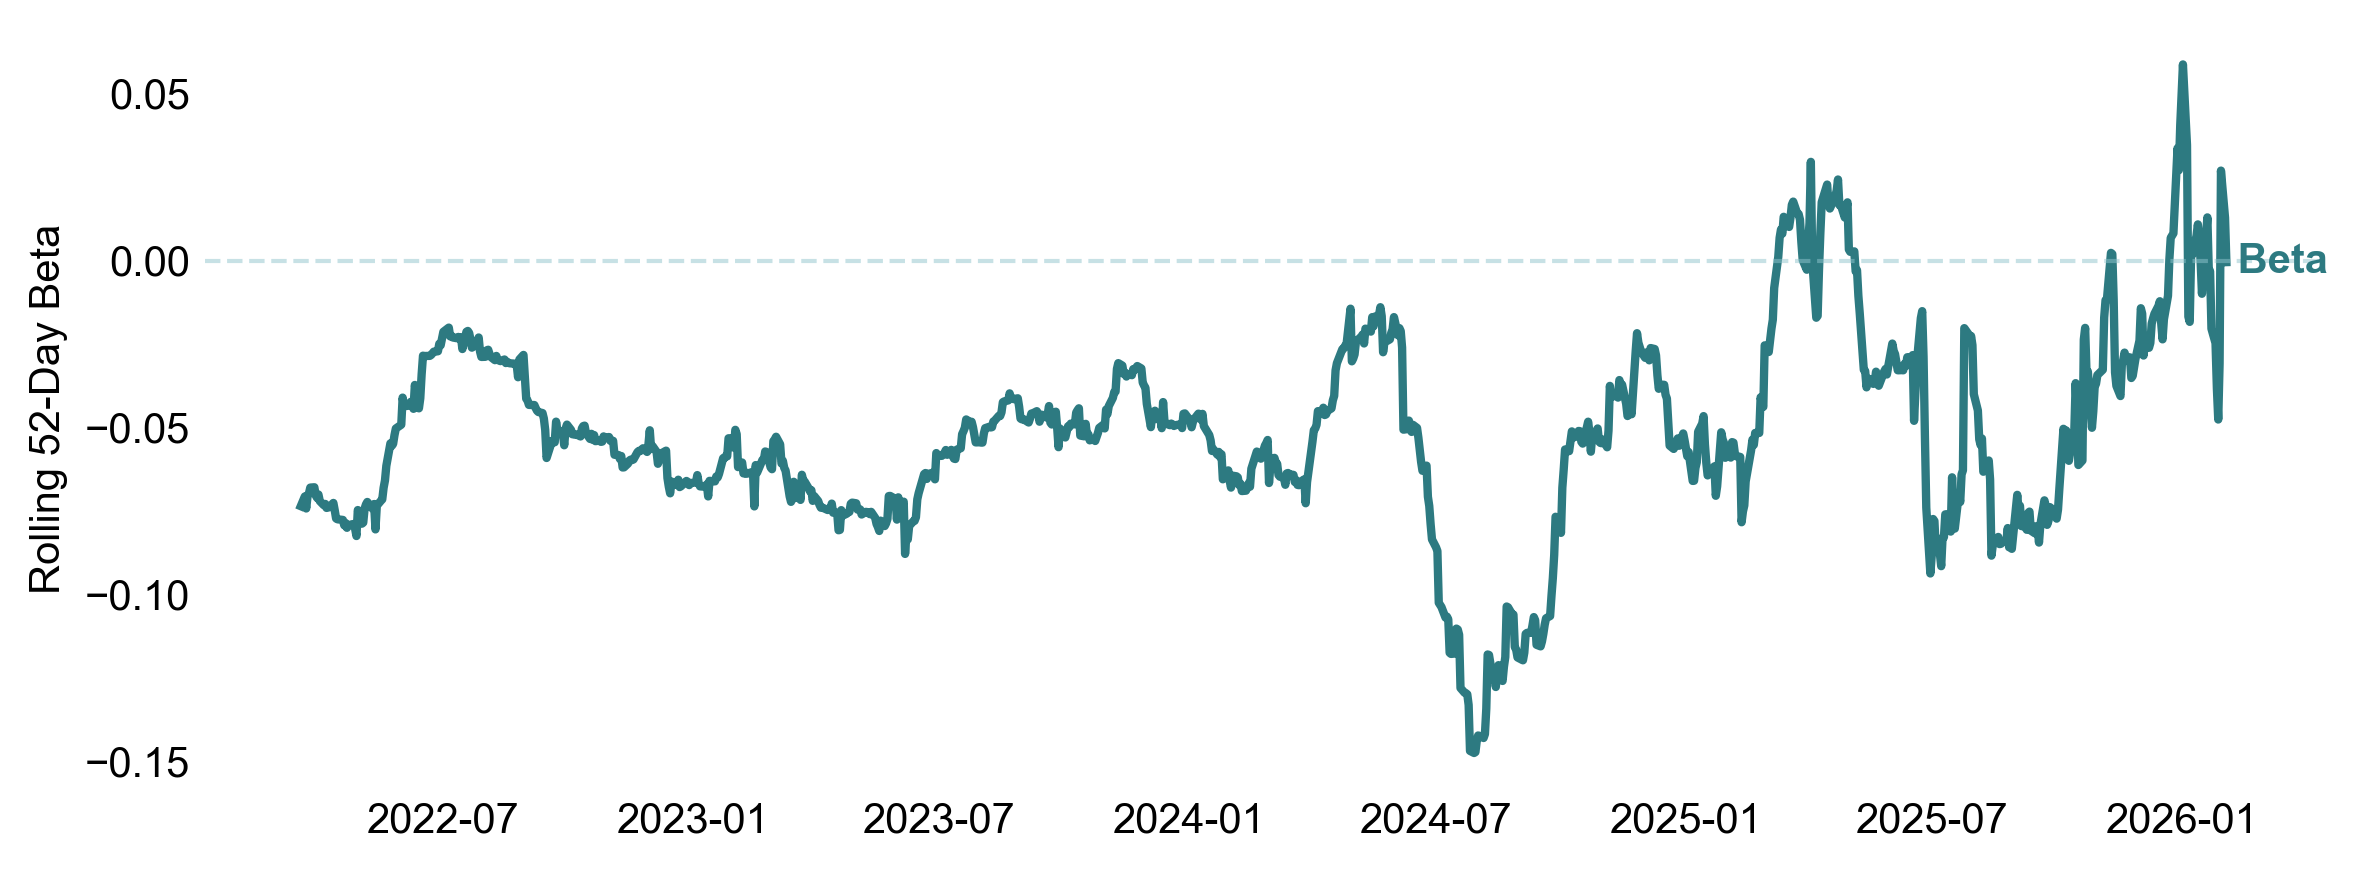

In [10]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=300)

ax.plot(rolling_beta.index, rolling_beta, color='#2D7A81', linewidth=2)
ax.axhline(y=0, color='#90C5CD', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('Rolling 52-Day Beta', fontsize=10)
ax.tick_params(axis='both', length=0)

last_date = rolling_beta.index[-1]
last_beta = rolling_beta.iloc[-1]
ax.text(last_date, last_beta, ' Beta', fontsize=10, color='#2D7A81', 
        va='center', ha='left', weight='bold')

for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(False)
fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/gold_tips_beta.png")
plt.show()

Import Google Trends Data for "how to buy Gold" searches in Canada/US

In [11]:
ca_searches = pd.read_csv("/Users/jdawg/Downloads/ca_2010_search.csv")
ca_searches.rename(columns={"how to buy gold":"CA Interest", 
                            "Time":"date"}, 
                   inplace=True)

us_searches = pd.read_csv("/Users/jdawg/Downloads/us_2010_search.csv")
us_searches.rename(columns={"how to buy gold":"US Interest",
                           "Time":"date"},
                   inplace=True)

ca_us_searches = ca_searches.merge(us_searches, how="inner", on="date")
ca_us_searches['date'] = pd.to_datetime(ca_us_searches['date'])

Get GLD Price and Volume Data from Yahoo Finance

In [12]:
gld_data = yf.download("GLD", start="2010-01-01", end="2026-02-04")
gld_df = gld_data[['Close', 'Volume']].reset_index()
gld_df.columns = ['date', 'gld_price', 'gld_volume']

/var/folders/0c/gwf3kkss2ls74cgdgxp9q88r0000gn/T/ipykernel_80670/1564307173.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gld_data = yf.download("GLD", start="2010-01-01", end="2026-02-04")
[*********************100%***********************]  1 of 1 completed


Merge GLD Data on Google Trends Data

In [13]:
gold_gld_df = gld_df.merge(ca_us_searches, how="inner", on="date")

Plot GLD and Search Data

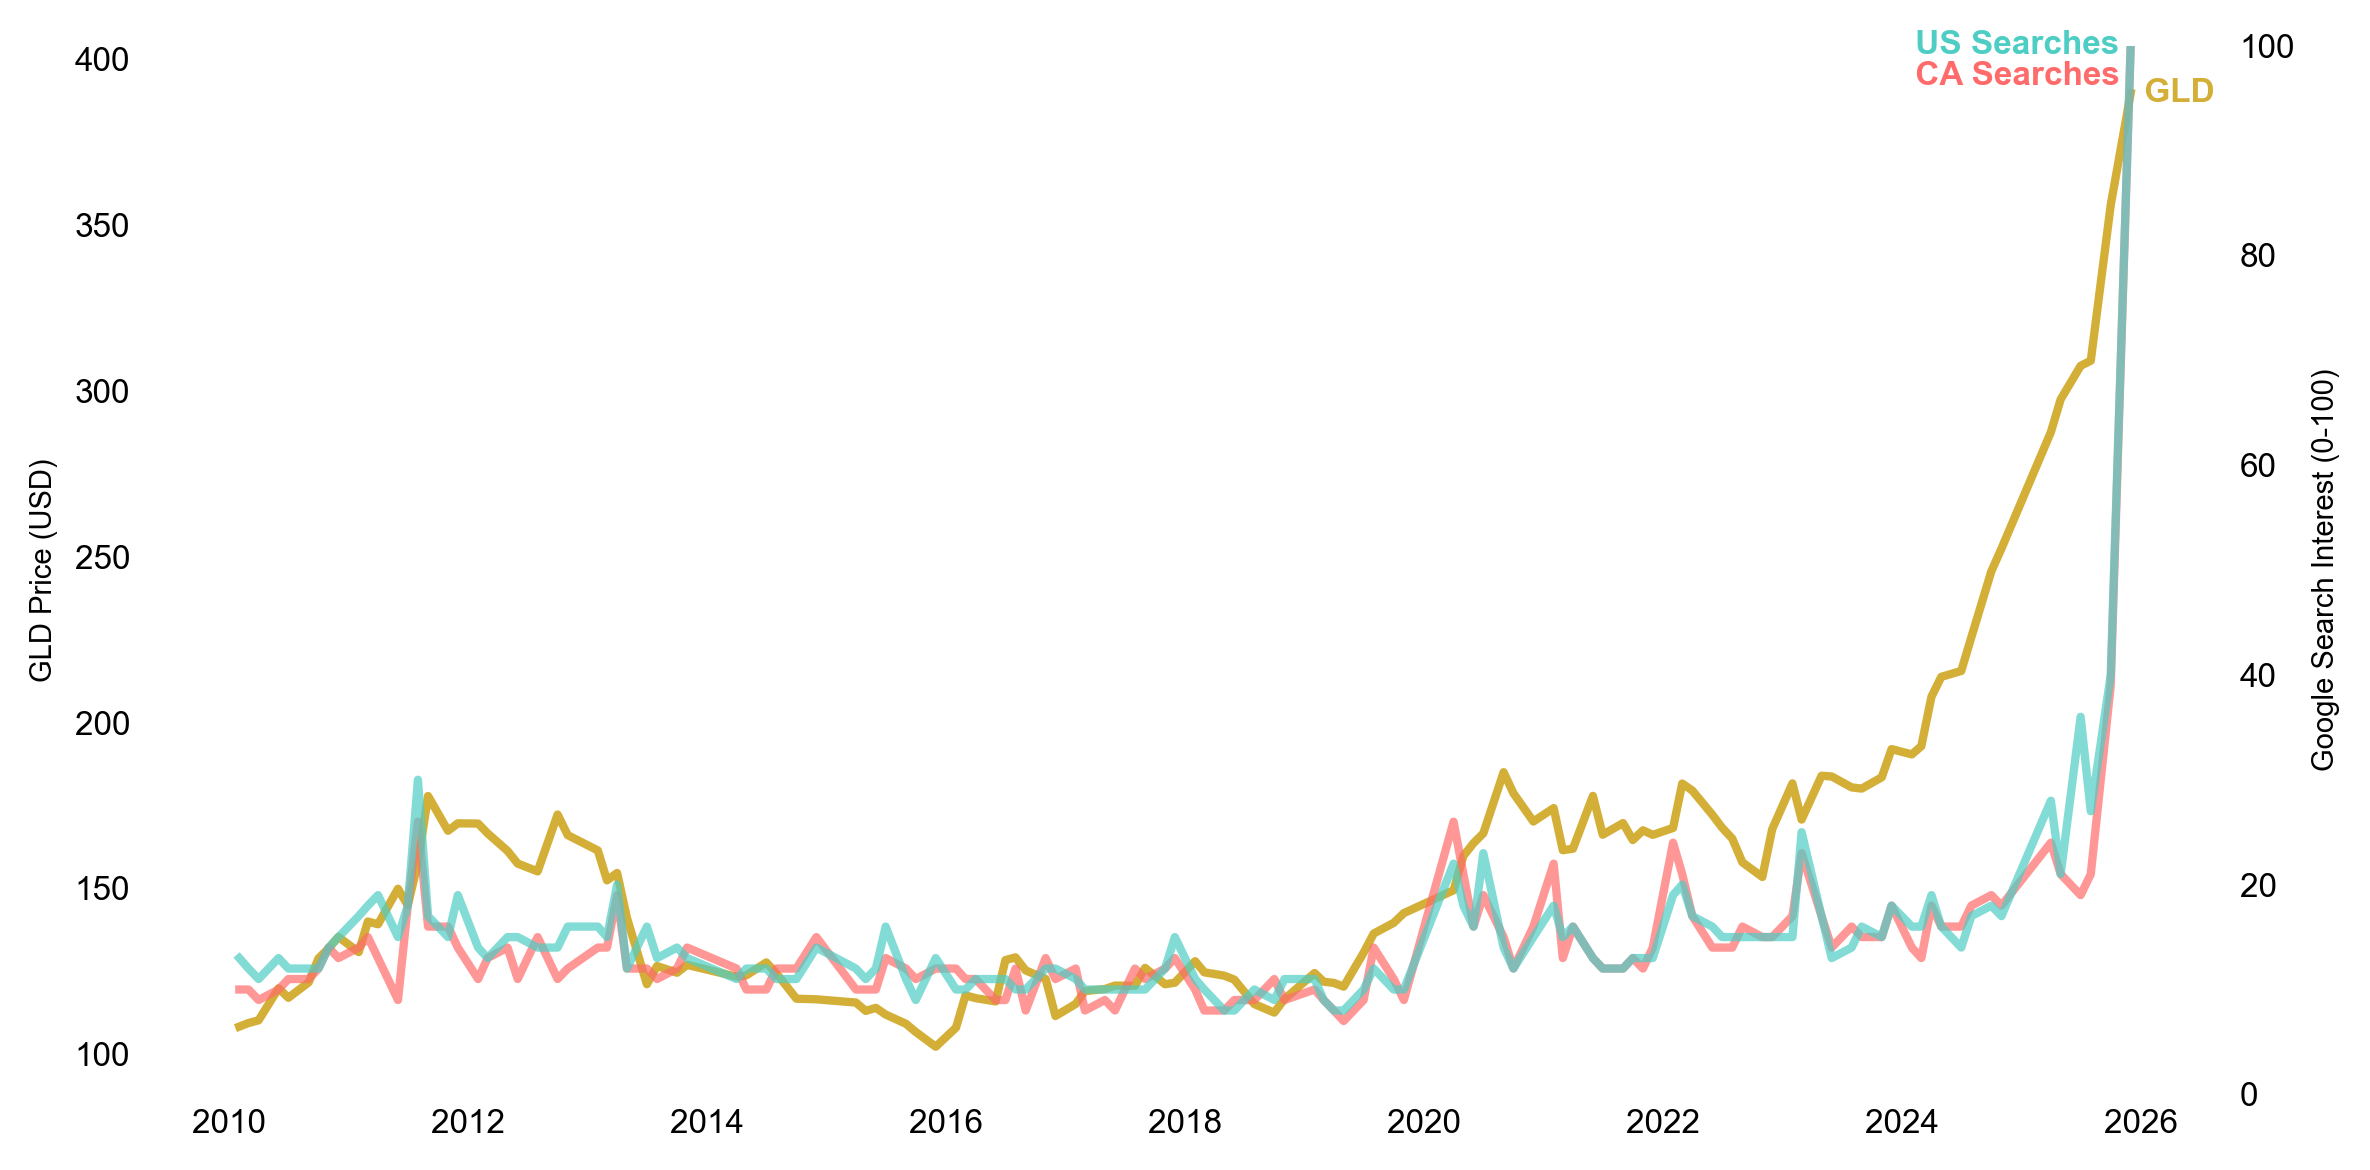

In [14]:
fig, ax1 = plt.subplots(figsize=(8, 4), dpi=300)

ax1.plot(gold_gld_df["date"], gold_gld_df["gld_price"], color="#D4AF37", linewidth=2, label="GLD Price (USD)")
ax1.set_ylabel("GLD Price (USD)", color="black", fontsize=7)
ax1.tick_params(axis="y", length=0, labelsize=8)
ax1.tick_params(axis="x", length=0, labelsize=8)

ax2 = ax1.twinx()

ax2.plot(gold_gld_df["date"], gold_gld_df["CA Interest"], color="#FF6B6B", linewidth=2, alpha=0.7, label="CA Search Interest")
ax2.plot(gold_gld_df["date"], gold_gld_df["US Interest"], color="#4ECDC4", linewidth=2, alpha=0.7, label="US Search Interest")
ax2.set_ylabel("Google Search Interest (0-100)", color="black", fontsize=7)
ax2.tick_params(axis="y", length=0, labelsize=8)
ax2.set_ylim(0, 100)
ax2.yaxis.set_major_locator(plt.MultipleLocator(20))

last_date = gold_gld_df["date"].iloc[-1]
last_gld = gold_gld_df["gld_price"].iloc[-1]
last_ca = gold_gld_df["CA Interest"].iloc[-1]
last_us = gold_gld_df["US Interest"].iloc[-1]
x_offset = pd.Timedelta(weeks=52)
ax1.text(last_date+pd.Timedelta(weeks=2), last_gld, ' GLD', fontsize=8, color='#D4AF37', 
         va='center', ha='left', weight='bold')
ax2.text(last_date-x_offset-pd.Timedelta(weeks=46), last_ca-3, ' CA Searches', fontsize=8, color='#FF6B6B', 
         va='center', ha='left', weight='bold')
ax2.text(last_date-x_offset-pd.Timedelta(weeks=46), last_us, ' US Searches', fontsize=8, color='#4ECDC4', 
         va='center', ha='left', weight='bold')

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax1.grid(False)
fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/gold_search_interest.png", bbox_inches='tight')
plt.show()

Import GLD Open Interest Data from Bloomberg

In [22]:
gld_oi_data = pd.read_csv("/Users/jdawg/Downloads/gld_open_interest.csv")

In [23]:
gld_oi_data = gld_oi_data.dropna(how='all')

In [24]:
gld_oi_data_filtered = gld_oi_data[["Date", "Sum of OI"]]

In [25]:
gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].replace(0, np.nan)
gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].fillna(method='ffill')

/var/folders/0c/gwf3kkss2ls74cgdgxp9q88r0000gn/T/ipykernel_80670/1714122563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].replace(0, np.nan)
/var/folders/0c/gwf3kkss2ls74cgdgxp9q88r0000gn/T/ipykernel_80670/1714122563.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].fillna(method='ffill')
/var/folders/0c/gwf3kkss2ls74cgdgxp9q88r0000gn/T/ipykernel_80670/1714122563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [26]:
gld_oi_data = pd.read_csv("/Users/jdawg/Downloads/gld_open_interest.csv")
gld_oi_data = gld_oi_data.dropna(how='all')
gld_oi_data_filtered = gld_oi_data[["Date", "Sum of OI"]].copy()

gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].replace(0, np.nan)
gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].ffill()
gld_oi_data_filtered['Date'] = pd.to_datetime(gld_oi_data_filtered['Date'])

gld_oi_data_filtered = gld_oi_data_filtered.dropna()

Plot Open Interest

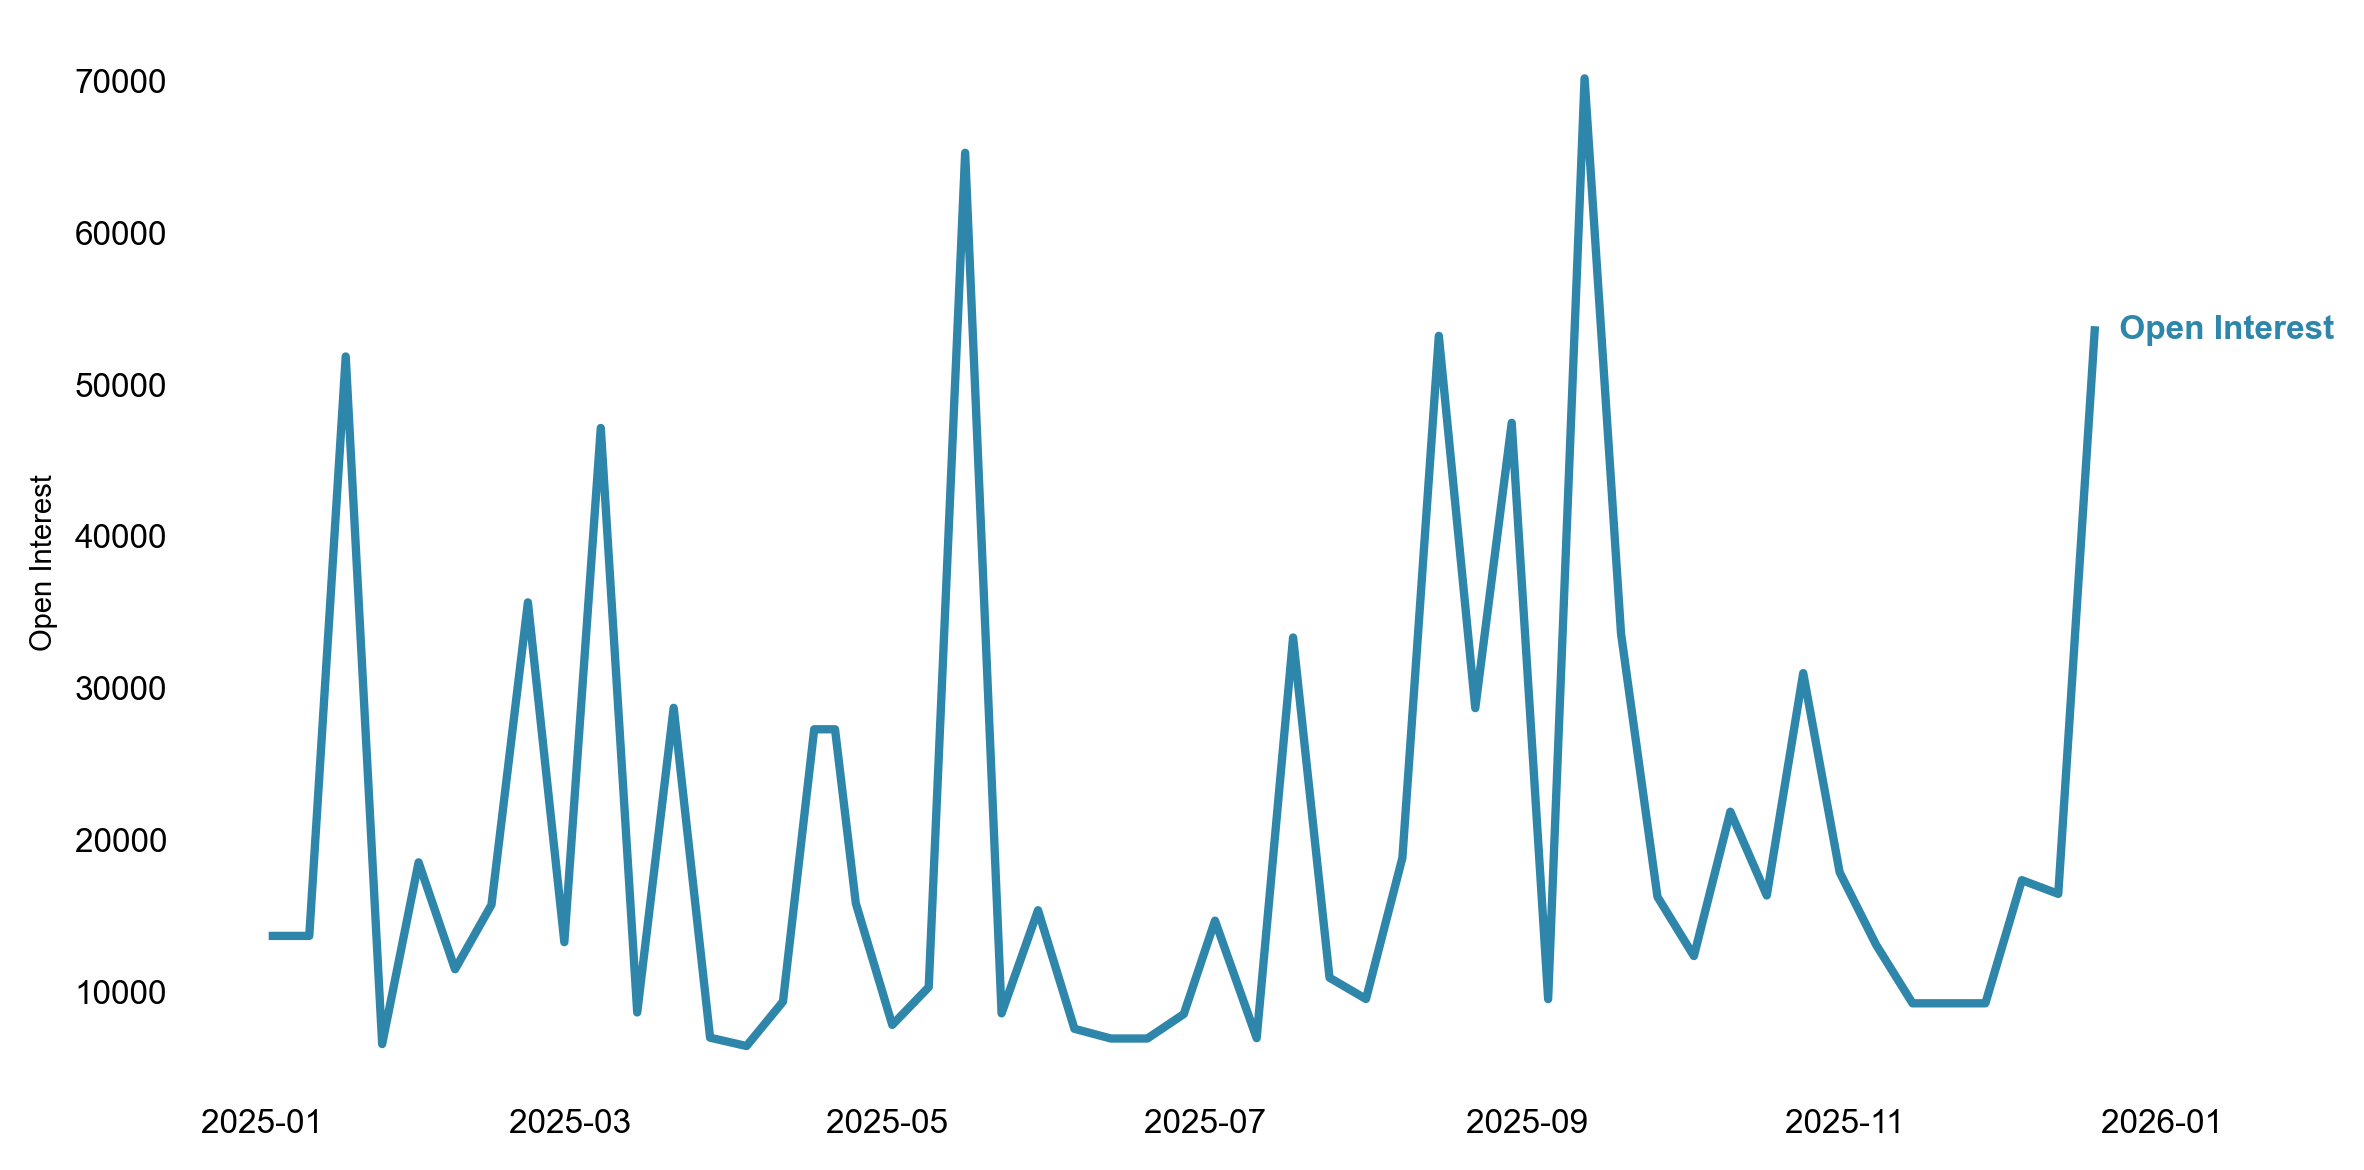

In [36]:
fig, ax1 = plt.subplots(figsize=(8, 4), dpi=300)

ax1.plot(gld_oi_data_filtered["Date"], 
         gld_oi_data_filtered["Sum of OI"], 
         color="#2E86AB", 
         linewidth=2, 
         label="Open Interest")

ax1.set_ylabel("Open Interest", color="black", fontsize=7)
ax1.tick_params(axis="y", length=0, labelsize=8)
ax1.tick_params(axis="x", length=0, labelsize=8)

last_date = gld_oi_data_filtered["Date"].iloc[-1]
last_oi = gld_oi_data_filtered["Sum of OI"].iloc[-1]

ax1.text(last_date + pd.Timedelta(days=3), last_oi, ' Open Interest', 
         fontsize=8, color='#2E86AB', va='center', ha='left', weight='bold')

for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.grid(False)

fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/gld_weekly_open_interest.png", bbox_inches='tight')
plt.show()

Import 2s10s Data from FRED (CSV)

In [37]:
ten_two = pd.read_csv("/Users/jdawg/Downloads/T10Y2Y.csv")

In [38]:
ten_two["T10Y2Y"] = ten_two["T10Y2Y"].ffill()
ten_two['observation_date'] = pd.to_datetime(ten_two['observation_date'])

ten_two_filtered = ten_two.dropna()

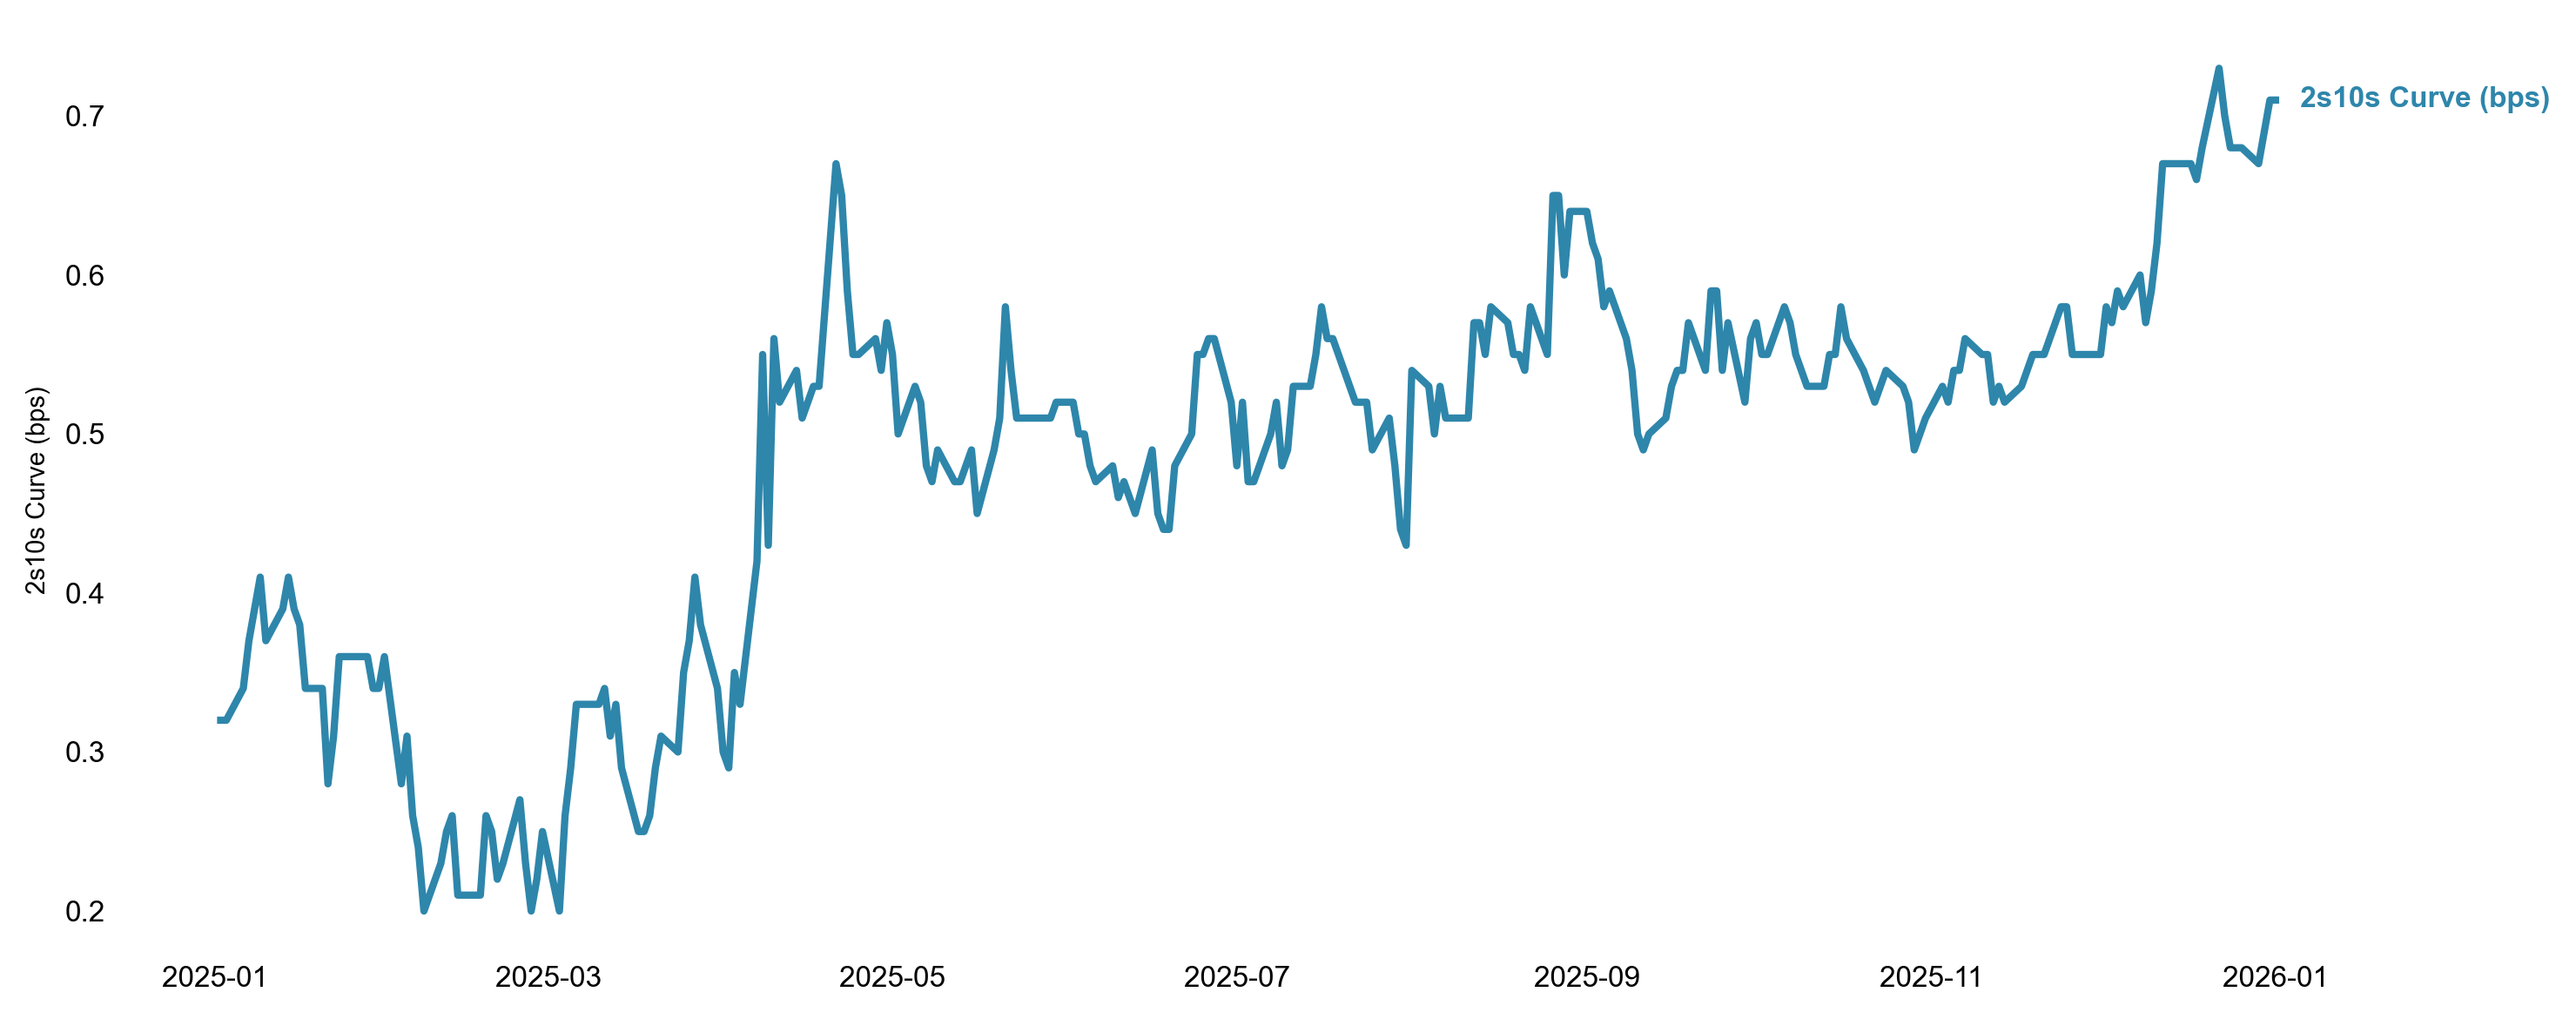

In [40]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(ten_two_filtered["observation_date"], 
         ten_two_filtered["T10Y2Y"], 
         color="#2E86AB", 
         linewidth=2, 
         label="2s10s Curve (bps)")

ax1.set_ylabel("2s10s Curve (bps)", color="black", fontsize=7)
ax1.tick_params(axis="y", length=0, labelsize=8)
ax1.tick_params(axis="x", length=0, labelsize=8)

last_date = ten_two_filtered["observation_date"].iloc[-1]
last_oi = ten_two_filtered["T10Y2Y"].iloc[-1]

ax1.text(last_date + pd.Timedelta(days=3), last_oi, ' 2s10s Curve (bps)', 
         fontsize=8, color='#2E86AB', va='center', ha='left', weight='bold')

for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.grid(False)

fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/2s10s.png", bbox_inches='tight')
plt.show()

In [41]:
usgg5y5y = pd.read_csv("/Users/jdawg/Downloads/T5YIFR (1).csv")
usgg5y5y.columns

usgg5y5y["T5YIFR"] = usgg5y5y["T5YIFR"].ffill()
usgg5y5y['observation_date'] = pd.to_datetime(usgg5y5y['observation_date'])

usgg5y5y_filtered = usgg5y5y.dropna()

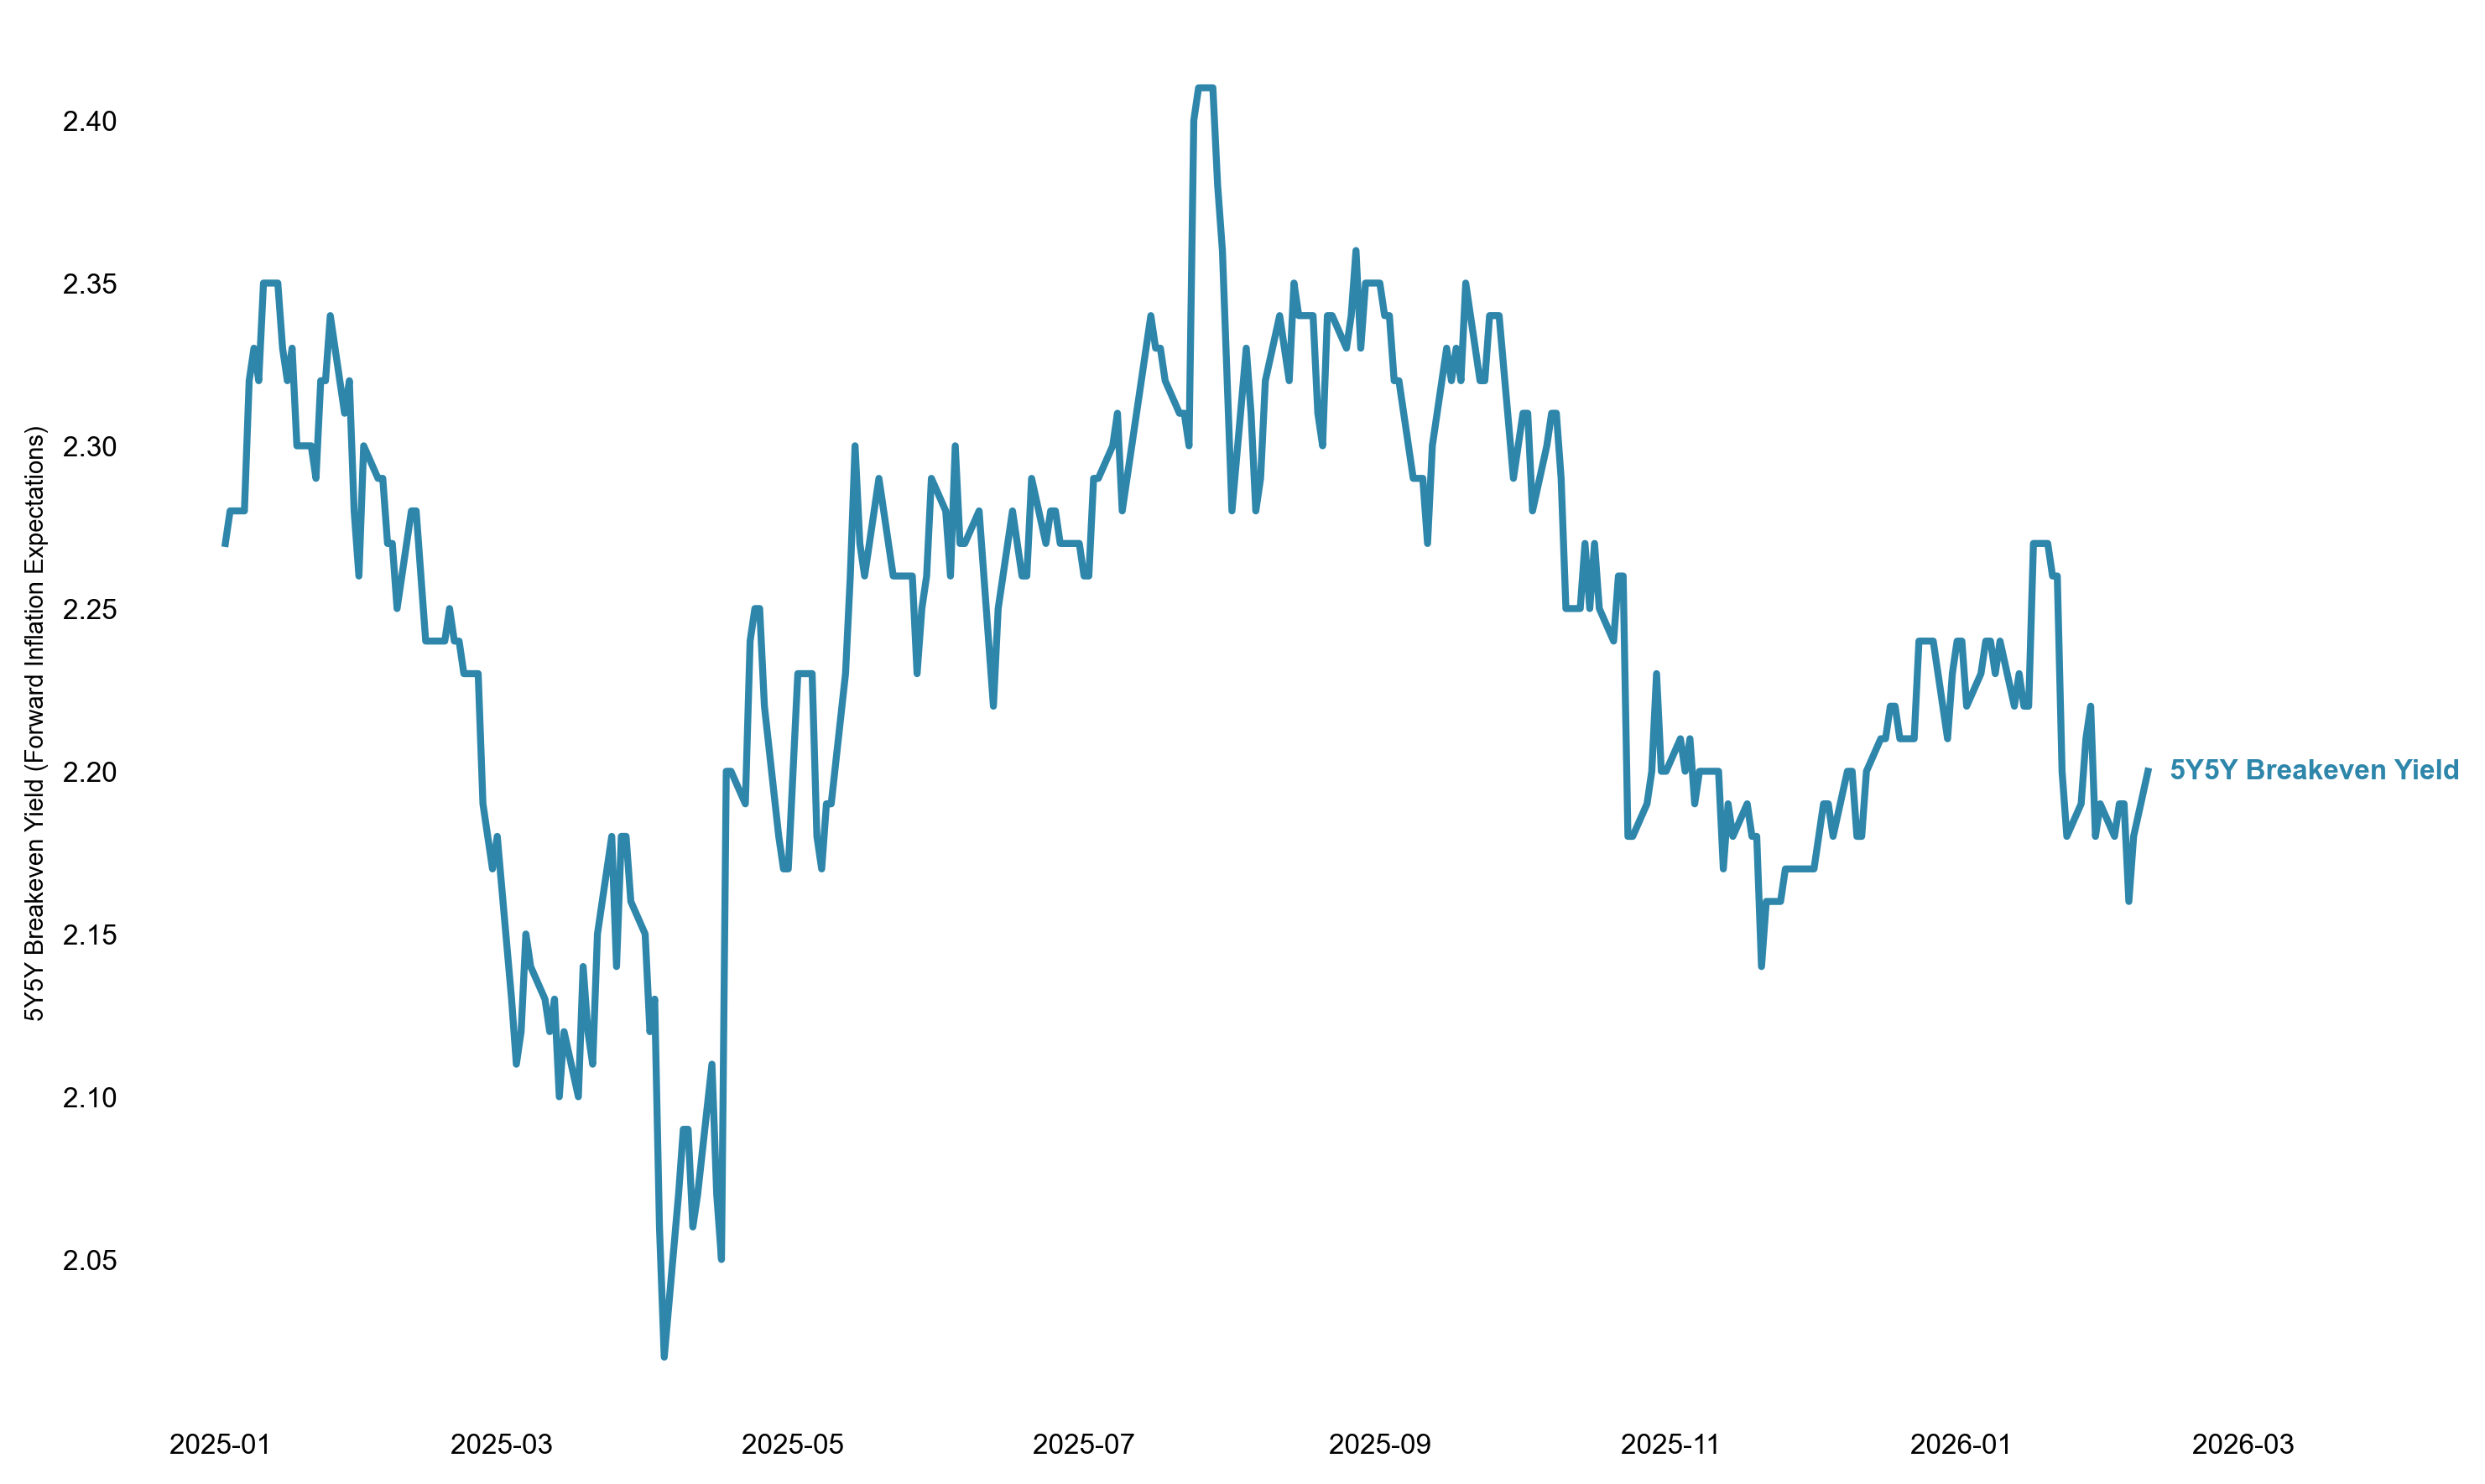

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)

ax1.plot(usgg5y5y["observation_date"], 
         usgg5y5y["T5YIFR"], 
         color="#2E86AB", 
         linewidth=2, 
         label="5Y5Y Breakeven Yield")

ax1.set_ylabel("5Y5Y Breakeven Yield (Forward Inflation Expectations)", color="black", fontsize=7)
ax1.tick_params(axis="y", length=0, labelsize=8)
ax1.tick_params(axis="x", length=0, labelsize=8)

last_date = usgg5y5y_filtered["observation_date"].iloc[-1]
last_oi = usgg5y5y_filtered["T5YIFR"].iloc[-1]

ax1.text(last_date + pd.Timedelta(days=3), last_oi, ' 5Y5Y Breakeven Yield', 
         fontsize=8, color='#2E86AB', va='center', ha='left', weight='bold')

for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.grid(False)

fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/usgg5y5y.png", bbox_inches='tight')
plt.show()

In [44]:
long_term_5y5y = pd.read_csv("/Users/jdawg/Downloads/T5YIFR (2).csv")

long_term_5y5y["T5YIFR"] = long_term_5y5y["T5YIFR"].ffill()
long_term_5y5y['observation_date'] = pd.to_datetime(long_term_5y5y['observation_date'])

long_term_5y5y_filtered = long_term_5y5y.dropna()

In [47]:
avg_ie_be = long_term_5y5y_filtered["T5YIFR"].mean()
avg_ie_be

np.float64(2.251118115461181)

In [48]:
data_30s = pd.read_csv("/Users/jdawg/Downloads/DGS30.csv")
data_2s = pd.read_csv("/Users/jdawg/Downloads/DGS2.csv")

s2s30_series = data_30s.merge(data_2s,how="inner",on="observation_date")
s2s30_series["2s30s"] = s2s30_series["DGS30"]-s2s30_series["DGS2"]
s2s30_series = s2s30_series[["observation_date", "2s30s"]]
s2s30_series

,observation_date,2s30s
0,2025-01-02,0.54
1,2025-01-03,0.54
2,2025-01-06,0.57
3,2025-01-07,0.61
4,2025-01-08,0.63
...,...,...
282,2026-02-02,1.33
283,2026-02-03,1.33
284,2026-02-04,1.34
285,2026-02-05,1.38


In [49]:
s2s30_series["2s30s"] = s2s30_series["2s30s"].ffill()
s2s30_series['observation_date'] = pd.to_datetime(s2s30_series['observation_date'])

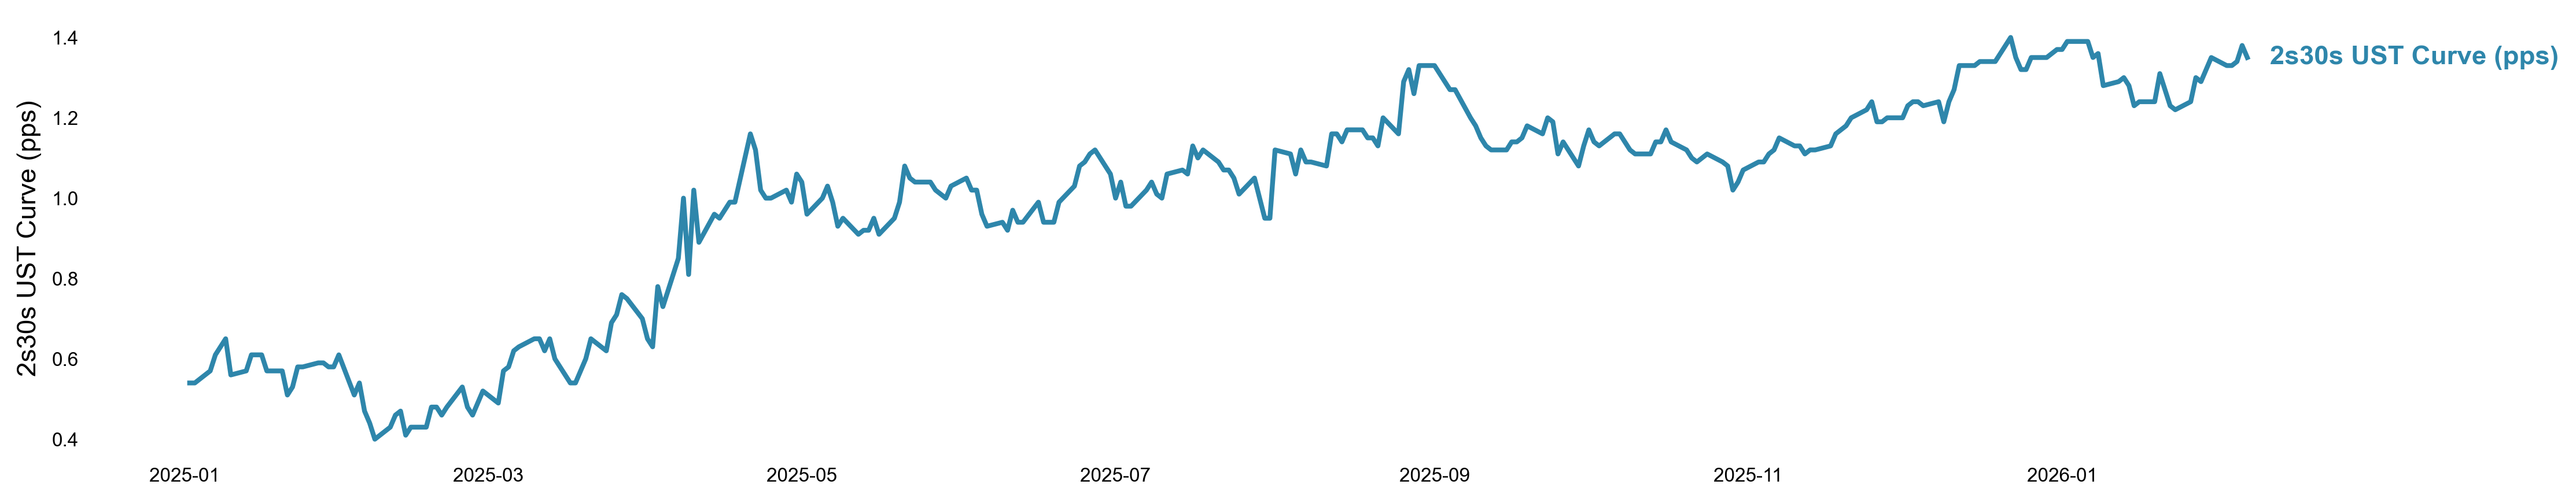

In [50]:
fig, ax1 = plt.subplots(figsize=(15, 3), dpi=300)

ax1.plot(s2s30_series["observation_date"], 
         s2s30_series["2s30s"], 
         color="#2E86AB", 
         linewidth=2, 
         label="5Y5Y Breakeven Yield")

ax1.set_ylabel("2s30s UST Curve (pps)", color="black", fontsize=11)
ax1.tick_params(axis="y", length=0, labelsize=8)
ax1.tick_params(axis="x", length=0, labelsize=8)

last_date = s2s30_series["observation_date"].iloc[-1]
last_oi = s2s30_series["2s30s"].iloc[-1]

ax1.text(last_date + pd.Timedelta(days=3), last_oi, ' 2s30s UST Curve (pps)', 
         fontsize=11, color='#2E86AB', va='center', ha='left', weight='bold')

for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.grid(False)

fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/us2s30s.png", bbox_inches='tight')
plt.show()